### Business otázky
vytvořit systém "objektivního" skórování, který umožňuje efektivněji porovnat hotely na základě těchto otázek  
* jaký je vztah sentimentu a skóre?
* jaký vliv má národnost na výsledné skóre
* jaký vliv mají tagy na skóre
* jaký vliv má počet hodnocení na skóre




### Technologicke reseni
!! neni nutne udelat vsechny

* Načtěte dataset do datového rámce (DONE)
* Vytvořte přínosné vizualizace 
* Vytvořte přínosnou kontingenční tabulku 
* Vytvořte přínosnou korelační matici (DONE)
* Extrahujte z textů pojmenované entity a uložte je pro budoucí zpracování 
* Extrahujte z textů zajímavá slovní spojení a uložte je pro budoucí zpracování 
* Extrahujte z textu sentiment v návaznosti na entity 
* Extrahujte z textu jazykový styl pisatele 
* Najděte nejpodobnější/nejodlišnější recenze pomocí vzdálenosti vektorů dokumentů 
* Natrénujte klasifikátor sentimentu 
* Natrénujte klasifikaci národnosti podle textu příspěvku 

In [5]:
import pandas as pd
import spacy
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

from sklearn import metrics 
import numpy as np 

In [6]:
hotel = pd.read_csv("Hotel_Reviews.csv")

In [ ]:
hotel

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11.0,7.0,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105.0,7.0,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21.0,9.0,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26.0,1.0,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8.0,3.0,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488239,Via Senato 22 Milan City Center 20121 Milan Italy,116,11/12/2015,9.0,Senato Hotel Milano,Saudi Arabia,The room was very small,7,1031,The location and cleanless,5.0,9.0,6.3,"[' Leisure trip ', ' Solo traveler ', ' Single...",630 day,45.471406,9.196530
488240,Via Senato 22 Milan City Center 20121 Milan Italy,116,11/12/2015,9.0,Senato Hotel Milano,United States of America,The pendant lights at the night stand only wo...,17,1031,Nicely designed hotel Good location near the ...,10.0,7.0,8.8,"[' Leisure trip ', ' Couple ', ' Double Room '...",630 day,45.471406,9.196530
488241,Via Senato 22 Milan City Center 20121 Milan Italy,116,11/10/2015,9.0,Senato Hotel Milano,Turkey,No Negative,0,1031,Rooms Breakfast Location,4.0,3.0,10.0,"[' Leisure trip ', ' Couple ', ' Double Room '...",632 day,45.471406,9.196530
488242,Via Senato 22 Milan City Center 20121 Milan Italy,116,11/8/2015,9.0,Senato Hotel Milano,India,No Negative,0,1031,Excellent ambience created by very thoughtful...,10.0,4.0,9.2,"[' Leisure trip ', ' Solo traveler ', ' Classi...",634 day,45.471406,9.196530


drop columns with missing values and reset index

In [7]:
hotel = hotel.dropna()
hotel = hotel.reset_index(drop=True)

### Vizualizace

#### popisná statistika
uvnitř v souboru report.html

In [ ]:
profile = ProfileReport(hotel)
profile.to_file("report.html")

#### korelační matice

<AxesSubplot:>

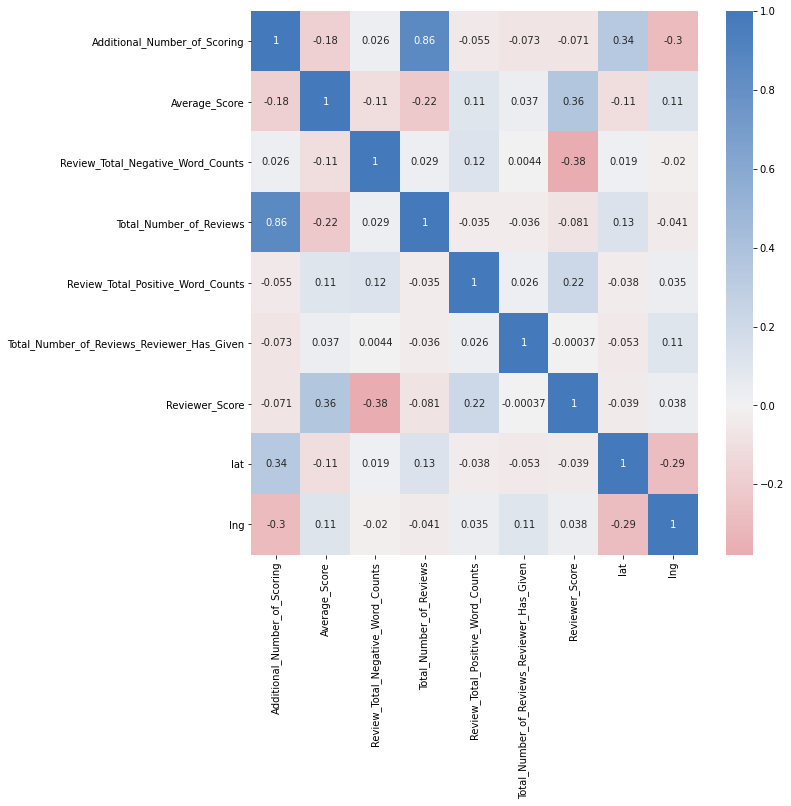

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(hotel.corr(), annot=True, cmap=sns.diverging_palette(10, 250, as_cmap=True), center=0)

#### histogram skóre

<AxesSubplot:xlabel='Reviewer_Score', ylabel='Count'>

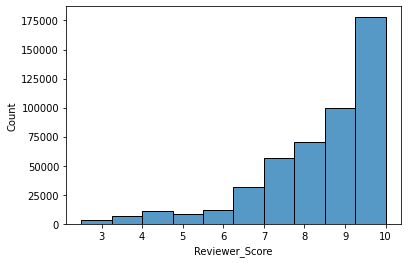

In [ ]:
sns.histplot(x='Reviewer_Score', data=hotel, bins=10)

#### top # recenzentu podle národnosti (relativní počty)
* velká část recenzentů z UK

<AxesSubplot:xlabel='relative_counts', ylabel='Reviewer_Nationality'>

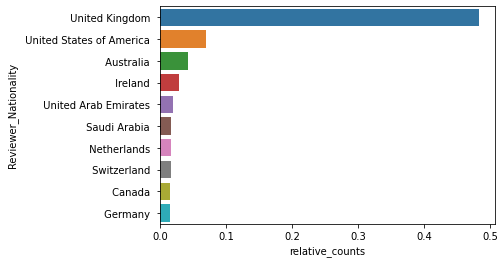

In [ ]:
top_n = 10
reviewers_counts = pd.DataFrame(hotel.groupby('Reviewer_Nationality')['Hotel_Name'].count().sort_values(ascending=False))
reviewers_counts.columns = ['counts']
top_reviewers = reviewers_counts[:top_n] # get top n
top_reviewers = top_reviewers.reset_index()
top_reviewers['relative_counts'] = top_reviewers['counts'] / hotel.shape[0]

sns.barplot(x='relative_counts', y='Reviewer_Nationality', data=top_reviewers)

#### top # hotelů podle průměrného skóre

In [ ]:
hotel_unique = hotel.drop_duplicates('Hotel_Name')
hotel_top_avg = hotel_unique.sort_values(by='Average_Score', ascending=False).reset_index()[:top_n]
hotel_top_avg[['Hotel_Name', 'Average_Score']]

,Hotel_Name,Average_Score
0,Ritz Paris,9.8
1,41,9.6
2,H10 Casa Mimosa 4 Sup,9.6
3,Hotel The Serras,9.6
4,Haymarket Hotel,9.6
5,H tel de La Tamise Esprit de France,9.6
6,Hotel Casa Camper,9.6
7,The Soho Hotel,9.5
8,Milestone Hotel Kensington,9.5
9,Waldorf Astoria Amsterdam,9.5


POJMENOVANÉ ENTITY

In [ ]:
nlp = spacy.load("en_core_web_md")
print(nlp)

/opt/venv/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_md' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.4). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
new = hotel["Positive_Review"].copy() 
hotel["Review"] = hotel["Negative_Review"].str.cat(new, sep =". ") 
hotel["Review"]

0          I am so angry that i made this post available...
1         No Negative.  No real complaints the hotel was...
2          Rooms are nice but for elderly a bit difficul...
3          My room was dirty and I was afraid to walk ba...
4          You When I booked with your company on line y...
                                ...                        
485582    No Negative.  Beautiful design perfect locatio...
485583     The room was very small .  The location and c...
485584     The pendant lights at the night stand only wo...
485585               No Negative.  Rooms Breakfast Location
485586    No Negative.  Excellent ambience created by ve...
Name: Review, Length: 477671, dtype: object

In [2]:
hotel_sample = hotel.sample(frac=0.01, random_state=1)
hotel_sample.shape

NameError: name 'hotel' is not defined

In [ ]:
hotel_sample.sample(15, random_state=1)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,sentiment,Review
54640,15 Montague St Bloomsbury Camden London WC1B 5...,196,3/5/2016,9.3,The Montague On The Gardens,United Kingdom,No Negative,0,931,Wonderfully welcoming staff Room was really d...,17.0,16.0,10.0,"[' Business trip ', ' Solo traveler ', ' Class...",516 day,51.520181,-0.125696,POSITIVE,No Negative. Wonderfully welcoming staff Room...
274616,Aspernbr ckengasse 1 02 Leopoldstadt 1020 Vien...,160,11/23/2016,8.1,Novotel Wien City,United States of America,free wifi had no password protection and chec...,84,1632,great location,4.0,32.0,6.3,"[' Business trip ', ' Solo traveler ', ' Stand...",253 day,48.213425,16.383131,POSITIVE,free wifi had no password protection and chec...
422071,Putget 68 Sarri St Gervasi 08023 Barcelona Spain,258,2/26/2017,7.4,Catalonia Park Putxet,Italy,The bathroom without any wings to throw out a...,23,3590,Price and the staff was really kind,9.0,2.0,9.2,"[' Leisure trip ', ' Couple ', ' Double or Twi...",158 day,41.407281,2.144312,POSITIVE,The bathroom without any wings to throw out a...
137927,3 South Place City of London London EC2M 2AF U...,235,9/29/2015,9.3,South Place Hotel,United Kingdom,No Negative,0,769,From the moment we stepped through the door w...,45.0,2.0,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",674 day,51.518918,-0.086601,POSITIVE,No Negative. From the moment we stepped throu...
402916,Piazza della Repubblica 20 Central Station 201...,116,4/13/2017,8.5,The Westin Palace,South Africa,No Negative,0,736,The staff was nice,5.0,1.0,7.9,"[' Leisure trip ', ' Group ', ' Deluxe Imperia...",112 day,45.479036,9.199028,POSITIVE,No Negative. The staff was nice
190786,44 Grosvenor Square Westminster Borough London...,806,9/18/2016,7.8,Millennium Hotel London Mayfair,Qatar,Bad guest service,5,3117,No Positive,0.0,9.0,2.5,"[' Leisure trip ', ' Family with young childre...",319 day,51.510574,-0.150995,NEGATIVE,Bad guest service . No Positive
3719,1 3 Queens Garden Westminster Borough London W...,1058,9/21/2015,7.7,The Park Grand London Paddington,Australia,No Negative,0,4380,Staff great location,4.0,6.0,7.9,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",682 day,51.514218,-0.180903,POSITIVE,No Negative. Staff great location
237332,7 Pepys Street City of London London EC3N 4AF ...,1936,3/20/2017,8.7,DoubleTree by Hilton Hotel London Tower of London,United Kingdom,Only half of the lifts worked,7,7491,No Positive,0.0,1.0,9.2,"[' Leisure trip ', ' Couple ', ' Queen Room ',...",136 day,51.510841,-0.078058,POSITIVE,Only half of the lifts worked. No Positive
356512,King William Walk Greenwich London SE10 9JW Un...,484,11/1/2016,8.2,De Vere Devonport House,United Kingdom,Wifi reception in rooms,6,1827,Clean quiet room with comfy bed and good show...,20.0,6.0,7.9,"[' Leisure trip ', ' Couple ', ' Double Room '...",275 day,51.480672,-0.007137,POSITIVE,Wifi reception in rooms . Clean quiet room w...
240521,7 Western Gateway Royal Victoria Dock Newham L...,359,7/8/2016,8.5,Novotel London Excel,United Kingdom,No Negative,0,1158,Good view to the river Set up of the hotel an...,15.0,3.0,9.5,"[' Leisure trip ', ' Family with young childre...",391 day,51.507720,0.022981,POSITIVE,No Negative. Good view to the river Set up of...


In [ ]:
hotel_sample = hotel_sample.drop(columns=['Review_Date', ])

In [1]:
hotel_reviews = hotel_sample["Review"].str.cat(sep='. ')

NameError: name 'hotel_sample' is not defined

In [ ]:
hotel_reviews

' The room didn t have a fridge so that we could keep our water cold .  It was in a great location so easy to get to anywhere The concierge was very helpful .  Breakfast.  Location friendly staff.  I am sorry I liked every thing AVERY pleasent.  The staff is excellent Ready to help always The food was very good fresh and the idea of supper is also very good the hotel is very clean the rooms are big enough One get full value for money .  By stander infront of mcdo.  Very affordable hotel in paris with pool transfort nearby.  Had to pay extra on departure apparently bookings com gave us the wrong price .  Great room and location for winter wonderland and shopping.  Only buffet food for a kitchen open till 10 30 this is pretty poor for a hotel which has 300 plus room At least have a bar menu were i can order some snacks .  The room.  Almost had to put up with the room for wheelchair people although they claimed it is a standard room but I d be very upset if I hadn t got to change to a nor

In [ ]:
named_entities = pd.DataFrame()

for ent in nlp(str(hotel_reviews)).ents:
    named_entities.loc[ent.text, "ent.start_char"] = ent.start_char
    named_entities.loc[ent.text, "ent.end_char"] = ent.end_char
    named_entities.loc[ent.text, "ent.label_"] = ent.label_
   
named_entities

KernelInterrupted: Execution interrupted by the Jupyter kernel.

SENTIMENT ANALÝZA

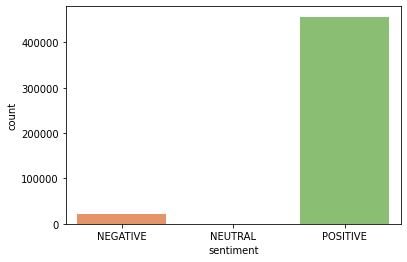

In [ ]:
hotel["sentiment"] = pd.cut(hotel["Reviewer_Score"], 
                   bins=[0,4.9,5,10], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
sns.countplot(x="sentiment", data=hotel, palette="RdYlGn");

Odstranění neutrální kategorie

In [ ]:
indicies_to_drop = hotel[hotel.sentiment == "NEUTRAL"].index

In [ ]:
hotel = hotel.drop(indicies_to_drop)

CategoricalDtype(categories=['NEGATIVE', 'POSITIVE'], ordered=True)

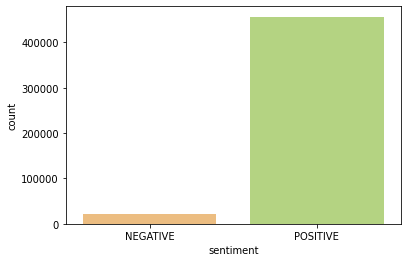

In [ ]:
hotel.sentiment = hotel.sentiment.cat.remove_unused_categories() #odstrani tu prazdnou neutral kategorii!
sns.countplot(x="sentiment", data=hotel, palette="RdYlGn")
hotel.sentiment.dtype

Vyvážení dat

In [ ]:
hotel_neg = hotel[hotel.sentiment=="NEGATIVE"]
hotel_pos = hotel[hotel.sentiment=="POSITIVE"]

In [ ]:
hotel.groupby("sentiment")["Reviewer_Score"].count()

sentiment
NEGATIVE     20839
POSITIVE    456832
Name: Reviewer_Score, dtype: int64

In [ ]:
hotel_sample_sent = hotel.sample(frac=0.01, random_state=1)
hotel_sample_sent.groupby("sentiment")["Reviewer_Score"].count()

sentiment
NEGATIVE     224
POSITIVE    4553
Name: Reviewer_Score, dtype: int64

In [ ]:
hotel_neg = hotel_sample_sent[hotel_sample_sent.sentiment=="NEGATIVE"]
hotel_pos = hotel_sample_sent[hotel_sample_sent.sentiment=="POSITIVE"]

In [ ]:
hotel_pos = hotel_sample_sent.sample(300)

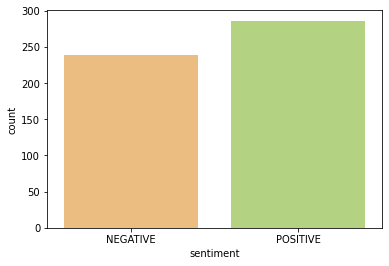

In [ ]:
hotel_bl = pd.concat([hotel_neg, hotel_pos], ignore_index=True) #dame to pak dohromady
sns.countplot(x="sentiment", data=hotel_bl, palette="RdYlGn");

Příprava formátu kategorií pro trénink

In [ ]:
hotel_bl["cats"] = [{"POSITIVE": y=="POSITIVE", "NEGATIVE": y=="NEGATIVE"} for y in hotel_bl.sentiment]

Rozělení na trénovací a testovací data

In [ ]:
split = 0.8
split_row = int(len(hotel_bl) * split)

In [ ]:
hotel_test = hotel_bl[split_row:]
len(hotel_test)


105

In [ ]:
hotel_train = hotel_bl[:split_row]
len(hotel_train)


419

Formátování dat pro spaCy update a evaluate funkc

In [ ]:
train_data = list(zip(hotel_train["Review"], [{"cats": cats} for cats in hotel_train["cats"]]))
test_data = list(zip(hotel_test["Review"], [{"cats": cats} for cats in hotel_test["cats"]]))

train_data[:3]

[(' No hot water window at a construction place elevator didn t work room smells like sigaret bathroom for handicapped people wasn t comfortable. No Positive',
  {'cats': {'POSITIVE': False, 'NEGATIVE': True}}),
 (' Room and facilities.  Nothings',
  {'cats': {'POSITIVE': False, 'NEGATIVE': True}}),
 (' Everything.  Overpriced small room no air Do not stay there ',
  {'cats': {'POSITIVE': False, 'NEGATIVE': True}})]

Načtení jazykového modelu

In [ ]:
textcat = nlp.create_pipe("textcat",
                          config={"exclusive_classes": True,
                                  "architecture": "simple_cnn"})

In [ ]:
nlp.add_pipe(textcat, last=True)

In [ ]:
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

textcat.labels # výpis pro ověření

('POSITIVE', 'NEGATIVE')

In [ ]:
from spacy.util import minibatch, compounding


In [ ]:
batch_sizes = compounding(1.0, 32.0, 1.5)
for x in range(12): print(next(batch_sizes))

1.0
1.5
2.25
3.375
5.0625
7.59375
11.390625
17.0859375
25.62890625
32.0
32.0
32.0


In [ ]:
batch_sizes = compounding(1.0, 4.0, 1.5)
for batch in minibatch(train_data[1:5], size=batch_sizes):
    print("\nbatch:", len(batch), batch)


batch: 1 [(' Room and facilities.  Nothings', {'cats': {'POSITIVE': False, 'NEGATIVE': True}})]

batch: 1 [(' Everything.  Overpriced small room no air Do not stay there ', {'cats': {'POSITIVE': False, 'NEGATIVE': True}})]

batch: 2 [(' Tv not working. No Positive', {'cats': {'POSITIVE': False, 'NEGATIVE': True}}), (' Small dirty room Rip off price .  Location', {'cats': {'POSITIVE': False, 'NEGATIVE': True}})]


Trénink

In [ ]:
n_iter = 10

In [ ]:
dropout = 0.7

In [ ]:
pipe_exceptions = ["textcat"] #, "trf_wordpiecer", "trf_tok2vec"
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [ ]:
y = hotel_test["sentiment"] # ["POSITIVE", "NEGATIVE", "POSITIVE", "NEGATIVE", ...]
random_scores = np.random.rand(len(hotel_test.sentiment)) # náhodné skóre od 0 (NEGATIVE) do 1 (POSITIVE)

fpr, tpr, thresholds = metrics.roc_curve(y, random_scores, pos_label="POSITIVE") # kalkulace ROC

In [ ]:
metrics.auc(fpr, tpr)

0.3888888888888889

[Text(0.5, 0, 'False Positive'), Text(0, 0.5, 'True Positive')]

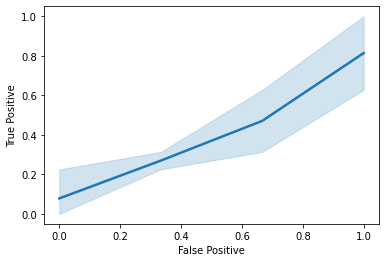

In [ ]:
plot = sns.lineplot(x=fpr, y=tpr, linewidth=2.5)
plot.set(xlabel='False Positive', ylabel='True Positive')

In [ ]:
import random

In [ ]:
score = pd.DataFrame() # dataframe pro výsledky
print("trénink", end="") # začátek tisku průběhu na řádek

with nlp.disable_pipes(other_pipes):  # s dočasně vypnutými ostatními pipes na trenovani toho naseho klasifikatoru
    
    optimizer = nlp.begin_training() # vytvoření optimalizátoru    
    
    for i in range(n_iter): # iterace přes celou tréninkovou množinu (epocha)
        print(".", end="") # tisk průběhu další iterace na řádek
        losses = {} # příprava pro ukládání informací o ztrátách        
        random.shuffle(train_data) # zamíchání tréninkovou množinou
        
        batch_sizes = compounding(8.0, 40.0, 1.2) # inicializace počtu příkladů ve várkách
        batches = minibatch(train_data, size=batch_sizes) # načtení příkladů ve várkách
        
        for batch in batches: # učení se na každé várce 
            texts, annotations = zip(*batch) # uložení polí dvojic do dvou separátních polí
            
            nlp.update(texts, annotations, sgd=optimizer, drop=dropout, losses=losses) # samotné učení a bere to pole anotaci
            
            #optimizer nam rika jak se zlepsujeme - jak sestupujeme po te gradiente
        
        with textcat.model.use_params(optimizer.averages): # s dočasnou aplikací aktualizovaného modelu
            scorer = nlp.evaluate(test_data) # evaluace modelu na testovacích datech
            
            # vyplnění tabulky se skórem modelu v iteraci
            score.loc[i, "loss"] = losses["textcat"] # zapsání končené ztráty do tabulky
            score.loc[i,"F"] = scorer.textcat_score            
            score.loc[i,"P+"] = scorer.textcats_per_cat["POSITIVE"]["p"]
            score.loc[i,"R+"] = scorer.textcats_per_cat["POSITIVE"]["r"]
            score.loc[i,"F+"] = scorer.textcats_per_cat["POSITIVE"]["f"]
            score.loc[i,"P-"] = scorer.textcats_per_cat["NEGATIVE"]["p"]
            score.loc[i,"R-"] = scorer.textcats_per_cat["NEGATIVE"]["r"]
            score.loc[i,"F-"] = scorer.textcats_per_cat["NEGATIVE"]["f"]
            
            #alternativní skórování pomocí ROC a balíčku sklearn
            docs_generator = nlp.pipe(hotel_test["Review"]) # dávkové zpracování testovacích dokumentů
            #generator dokumentu
            docs = list(docs_generator) # načtení testovacích dokumentů do listu
            scores = [doc.cats["POSITIVE"] for doc in docs] # načtení sentimentu do listu
            
            # kalkulace ROC
            fpr, tpr, thresholds = metrics.roc_curve(y_true = hotel_test["sentiment"], 
                                                     y_score = scores, 
                                                     pos_label = "POSITIVE")
            
            # vyplnění tabulky se skórem modelu v iteraci
            score.loc[i,"AUC"] = metrics.auc(fpr, tpr)
            
score #zobrazení tabulky se skóre po celém učení

trénink..........

,loss,F,P+,R+,F+,P-,R-,F-,AUC
0,0.029888,2.777778,0.0,0.000000,0.000000,2.857143,100.0,5.555556,0.699346
1,0.029484,2.777778,0.0,0.000000,0.000000,2.857143,100.0,5.555556,0.787582
2,0.030241,4.753266,100.0,1.960784,3.846154,2.912621,100.0,5.660377,0.807190
3,0.028634,3.774612,100.0,0.980392,1.941748,2.884615,100.0,5.607477,0.813725
4,0.027546,14.462243,100.0,12.745098,22.608696,3.260870,100.0,6.315789,0.843137
5,0.028944,21.230308,100.0,21.568627,35.483871,3.614458,100.0,6.976744,0.839869
6,0.025332,32.580779,100.0,39.215686,56.338028,4.615385,100.0,8.823529,0.849673
7,0.019882,40.170940,100.0,52.941176,69.230769,5.882353,100.0,11.111111,0.852941
8,0.023089,42.250000,100.0,56.862745,72.500000,6.382979,100.0,12.000000,0.846405
9,0.025216,48.592411,100.0,68.627451,81.395349,8.571429,100.0,15.789474,0.852941


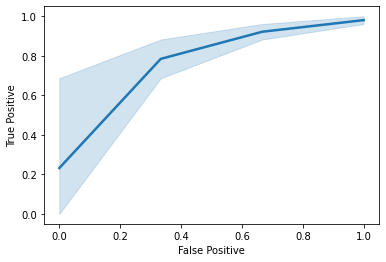

In [ ]:
#alternativní skórování pomocí ROC a balíčku sklearn
docs_generator = nlp.pipe(hotel_test["Review"]) # dávkové zpracování testovacích dokumentů
docs = list(docs_generator) # načtení testovacích dokumentů do listu
scores = [doc.cats["POSITIVE"] for doc in docs] # načtení sentimentu do listu

# kalkulace ROC
fpr, tpr, thresholds = metrics.roc_curve(y_true = hotel_test["sentiment"], 
                                         y_score = scores, 
                                         pos_label = "POSITIVE")

# zobrazení ROC grafu
roc_plot = sns.lineplot(x=fpr, y=tpr, linewidth=2.5)
roc_plot.set(xlabel='False Positive', ylabel='True Positive')
plt.show() # zobrazení křivky za běhu buňky

Vyzkoušení modelu na novém rámci

In [ ]:
examples = pd.DataFrame(["The rooms were clean.", "They went over and beyond to help make our stay enjoyable.",
                         "The breakfast is one of the best I have ever had in Europe.",
                         "I highly recommend this hotel for anyone visiting downtown", 
                         "We got to hotel super early", "The sevice was exceptional as well.",
                         "Every staff member I encountered were delightful and eager to help!",
                         "The bed was extremely comfortable.", "The room was spacious and clean.",
                         "Beautiful atmosphere inside and outside around that part of the city.",
                         "Everything what you need is possible.", "The room was huge, modern, and spotless.",
                         "This is a beautiful hotel!", "The environment was pleasant and welcoming.",
                         "We could park our motorcycles in the closed garage.", "Great value for money.",
                         "Must definitelly recommend breakfast, good food and variety of it.",
                         "Hot water constantly running out.", "Virtually no cooking utensils",
                         "Beds were extremely uncomfortable", "Pillows were solid hurting your neck when you slept.",
                         "My kid broke his arm there.", "Worst hotel I've stayed in.", "No Wi-Fi inside rooms.",
                         "Fridge was dirty and horrible and the bottom of it was rusty.", "Back-pain guaranteed.",
                         "Only way to let some fresh air inside is to open the main door.", 
                         "Limited hot water in apartments", "Barely slept all week.", 
                         "Staff are extremely rude and unhelpful", "Majority of hotel staff were miserable",
                         "Rooms smelt of cheap air freshener in an attempt to cover up a bad smell.",
                         "Furniture was cheap and didn't match (not a big deal)", "Smells very very ugly from bathroom.",
                         "standards were below what we were expecting."
                        ], 
                        columns=["text"])
examples

,text
0,The rooms were clean.
1,They went over and beyond to help make our sta...
2,The breakfast is one of the best I have ever h...
3,I highly recommend this hotel for anyone visit...
4,We got to hotel super early
5,The sevice was exceptional as well.
6,Every staff member I encountered were delightf...
7,The bed was extremely comfortable.
8,The room was spacious and clean.
9,Beautiful atmosphere inside and outside around...


In [ ]:
def evaluate(row, nlp=nlp):
    row["sentiment_score"]=nlp(row["text"]).cats["POSITIVE"]
    return row

In [ ]:
examples = examples.apply(evaluate, nlp=nlp, axis=1) # apply pro kazdy radek

examples["sentiment"] = pd.cut(examples["sentiment_score"], 
                   bins=[0,0.4,0.6,1], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
examples

,text,sentiment_score,sentiment
0,The rooms were clean.,0.994298,POSITIVE
1,They went over and beyond to help make our sta...,0.500684,NEUTRAL
2,The breakfast is one of the best I have ever h...,0.278954,NEGATIVE
3,I highly recommend this hotel for anyone visit...,0.910136,POSITIVE
4,We got to hotel super early,0.889683,POSITIVE
5,The sevice was exceptional as well.,0.986677,POSITIVE
6,Every staff member I encountered were delightf...,0.892293,POSITIVE
7,The bed was extremely comfortable.,0.985865,POSITIVE
8,The room was spacious and clean.,0.966698,POSITIVE
9,Beautiful atmosphere inside and outside around...,0.875640,POSITIVE


NEJPODOBNĚJŠÍ/NEJODLIŠNĚJŠÍ RECENZE POMOCÍ VDÁLENOSTI VEKTORŮ DOKUMENTŮ


In [ ]:
print(len(hotel_sample.index))

478


In [ ]:
hotel_reviews[:10]

' The room '

In [ ]:
vety = []

for radek in range (len(hotel_sample.index)):
    vety.append(nlp(hotel_sample["Review"].iloc[radek]))

In [ ]:
vety = [x for x in vety if len(x)>2]
vety

[ The room didn t have a fridge so that we could keep our water cold .  It was in a great location so easy to get to anywhere The concierge was very helpful ,
  Breakfast.  Location friendly staff,
  I am sorry I liked every thing AVERY pleasent.  The staff is excellent Ready to help always The food was very good fresh and the idea of supper is also very good the hotel is very clean the rooms are big enough One get full value for money ,
  By stander infront of mcdo.  Very affordable hotel in paris with pool transfort nearby,
  Had to pay extra on departure apparently bookings com gave us the wrong price .  Great room and location for winter wonderland and shopping,
  Only buffet food for a kitchen open till 10 30 this is pretty poor for a hotel which has 300 plus room At least have a bar menu were i can order some snacks .  The room,
  Almost had to put up with the room for wheelchair people although they claimed it is a standard room but I d be very upset if I hadn t got to change to

In [ ]:
len(vety)

478

In [ ]:
vectors = pd.DataFrame()

for vector in vety:
    vectors.loc[vector.text,"has_vector"] = vector.has_vector
    vectors.loc[vector.text,"vector_norm"] = vector.vector_norm

In [ ]:
vectors.sort_values("vector_norm")

,has_vector,vector_norm
La lentitud del check in check out. Limpio y cercano a Diagonal,True,2.471434
Nothing. Everything,True,2.513871
Expensive. Lovely views,True,2.572800
By stander infront of mcdo. Very affordable hotel in paris with pool transfort nearby,True,2.577268
Nothing. Super staff,True,2.582147
...,...,...
Very very poor wifi connection Too tiny breakfast room . Very convenient location Nice hotel nice people,True,3.595108
A little bit expensive but worth it . No Positive,True,3.595915
No Negative. Location hotel room shower staff,True,3.617516
No Negative. The breakfast was great Very friendly staff Nice quiet hotel in good location,True,3.634052


nejodlišnější je první a poslední 

# ANALÝZA NÁRODNOSTI

In [10]:
hotel.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

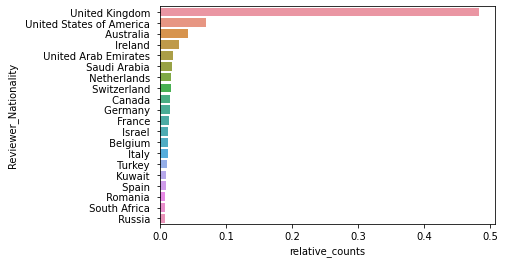

In [12]:
top_n = 20
reviewers_counts = pd.DataFrame(hotel.groupby('Reviewer_Nationality')['Hotel_Name'].count().sort_values(ascending=False))
reviewers_counts.columns = ['counts']
top_reviewers = reviewers_counts[:top_n] # get top n
top_reviewers = top_reviewers.reset_index()
top_reviewers['relative_counts'] = top_reviewers['counts'] / hotel.shape[0]

sns.barplot(x='relative_counts', y='Reviewer_Nationality', data=top_reviewers);

In [21]:
nationality = hotel.groupby(['Reviewer_Nationality', 'Hotel_Name'], as_index=False)['Negative_Review', 'Positive_Review', 'Reviewer_Score'].aggregate(
    {'Negative_Review':'sum','Positive_Review':'sum','Reviewer_Score':'sum'})


/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
nationality

In [14]:
hotel.shape

(485587, 17)